# NLP Sentiment Analysis

- **Author:** Sakthi Santhosh
- **Created on:** 04/02/2023

## To-Do

- Integerate ```TextVectorization``` layer into the model.

## Importing Modules

In [ ]:
from google.colab import drive
import os
from matplotlib import font_manager, pyplot, rcParams
from numpy import expand_dims
import pandas

from tensorflow.data import Dataset
from tensorflow.keras.layers import (
    Bidirectional,
    Dense,
    Dropout,
    Embedding,
    LSTM,
    TextVectorization
)
from tensorflow.keras.models import Sequential

## Global Declarations

In [ ]:
MAX_TOKENS = 300000
DATASET_LOCATION = "/content/gdrive/MyDrive/Sharing/Programming/python/ai/sentiment_analysis/"

## Downloading Datasets

In [ ]:
drive.mount("/content/gdrive/", force_remount=True)

## Load CSV File to Pandas Dataframe

In [ ]:
training_dataframe = pandas.read_csv(DATASET_LOCATION + "sentiment_analyser_dataset")

## Preprocess the Data

In [ ]:
training_data = {
    "comments": training_dataframe["comment_text"],
    "classifications": training_dataframe[
        training_dataframe.columns[2:]
    ].values
}

vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=1500,
    output_mode="int"
)
vectorizer.adapt(training_data["comments"].values)
vectorized_text = vectorizer(training_data["comments"].values)

dataset = Dataset.from_tensor_slices(
    (vectorized_text, training_data["classifications"])
).cache().shuffle(160000).batch(16).prefetch(8)
dataset_length = len(dataset)

partitioned_dataset = {
    "training": dataset.take(int(dataset_length * 0.7)),
    "testing": dataset.skip(int(dataset_length * 0.7)).take(int(dataset_length * 0.1)),
    "validation": dataset.skip(int(dataset_length * 0.8)).take(int(dataset_length * 0.2))
}

## Sequential Model Generation

In [ ]:
model = Sequential()

model.add(Embedding(MAX_TOKENS + 1, 32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="sigmoid"))

model.compile(loss="BinaryCrossentropy", optimizer="Adam")

## Train the Model

In [ ]:
history = model.fit(
    partitioned_dataset["training"],
    epochs=8,
    validation_data=partitioned_dataset["validation"],
    verbose=None
)

## Analysis of Epochs

<Figure size 576x360 with 0 Axes>

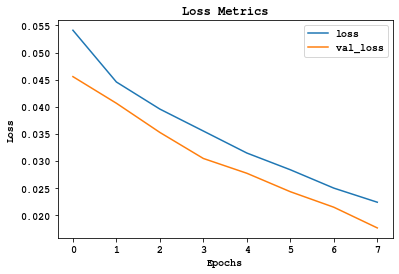

In [ ]:
font_manager.fontManager.addfont(DATASET_LOCATION + "FreeMonoBold.ttf")
rcParams["font.family"] = "FreeMono"

pyplot.figure(figsize=(8, 5))
pandas.DataFrame(history.history).plot()
pyplot.title("Loss Metrics")
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.show()

## Predict Text

In [ ]:
input_text = vectorizer("You are awesome!")
result = model.predict(expand_dims(input_text, 0), verbose=None)

print("\033[30;01mPrediction Results\033[00m")
print("  toxic:", result[0][0])
print("  severe_toxic:", result[0][1])
print("  obscene:", result[0][2])
print("  threat:", result[0][3])
print("  insult:", result[0][4])
print("  identity_hate:", result[0][5])

Prediction Results
  toxic: 0.042838726
  severe_toxic: 2.780846e-14
  obscene: 7.151756e-05
  threat: 0.0001372728
  insult: 0.0005819019
  identity_hate: 1.17863865e-05


## Export the Model

In [ ]:
model.save("./others/sentiment_analyser.h5")